<a href="https://colab.research.google.com/github/seenu-g/school_of_ai/blob/master/chap10/Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U git+https://github.com/albu/albumentations > /dev/null && echo "Albumentation library is successfully installed!"

  Running command git clone -q https://github.com/albu/albumentations /tmp/pip-req-build-tm5qfmox
Albumentation library is successfully installed!


In [2]:
# mount gdrive and unzip data
from google.colab import drive
import sys
%load_ext autoreload
%autoreload 2
drive.mount('/content/gdrive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
import sys
import os
folder = '/content/gdrive/My Drive/school_of_ai/chap10/'
os.chdir(folder)
print(os.getcwd()) 
for root, dirs, files in os.walk("."):
    for filename in files:
        print(filename)
sys.path.append(folder)

/content/gdrive/My Drive/school_of_ai/chap10
bestmodel.pt
TrialV6.ipynb
load_data.py
model.py
show_images.py
__init__.py
transforms.py
lr_finder.py
evaluate.py
plot.py
gradcam.py
train_test.py
__init__.cpython-36.pyc
load_data.cpython-36.pyc
show_images.cpython-36.pyc
model.cpython-36.pyc
evaluate.cpython-36.pyc
transforms.cpython-36.pyc
lr_finder.cpython-36.pyc
plot.cpython-36.pyc
gradcam.cpython-36.pyc
train_test.cpython-36.pyc
cifar-10-python.tar.gz
test_batch
data_batch_3
data_batch_2
data_batch_5
data_batch_1
data_batch_4
batches.meta
readme.html


In [4]:
%matplotlib inline
import torch
from template import load_data
from template import show_images
from template import model
from template import train_test
from template import evaluate
from template import transforms
from template import gradcam
from template import lr_finder
from template import plot

  pip install torch-lr-finder -v --global-option="amp"


In [0]:
import albumentations as A
train_transform_list = [
                          A.Rotate((-30.0, 30.0)),
                          A.HorizontalFlip(),
                          A.RGBShift(r_shift_limit=50, g_shift_limit=50, b_shift_limit=50, p=0.5),
                          A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
                          A.Cutout(num_holes=2, max_h_size=9,max_w_size = 9,p=0.7) # fillvalue is 0 after normalizing as mean is 0
                       ]
test_transform_list = [A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))]
train_transform = transforms.AlbumentationTransforms(train_transform_list)
test_transform = transforms.AlbumentationTransforms(test_transform_list)

In [6]:
classes, trainloader, testloader = load_data.load(train_transform,test_transform)

Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


**Some Training Data**

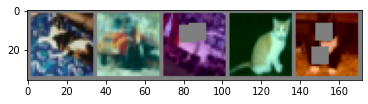

In [7]:
show_images.show_images(trainloader, classes)

**Print Model Summary**

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = model.ResNet18().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1,

In [9]:
pip install --no-cache-dir git+https://github.com/NVIDIA/apex > /dev/null && echo "Apex library is successfully installed!"

  Running command git clone -q https://github.com/NVIDIA/apex /tmp/pip-req-build-4944vwuj
  Running command git submodule update --init --recursive -q
Apex library is successfully installed!


**LR Finder - Finds the best possible LR**


In [10]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR , MultiStepLR

criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(model.parameters(), lr=0.00001,momentum=0.9 ,weight_decay = 0.0001)
lrfinder = lr_finder.LRFinder(model, optimiser, criterion, device="cuda")
lrfinder.range_test(trainloader, val_loader=testloader, end_lr=1, num_iter=600 ,step_mode="exp")


Learning rate search finished. See the graph with {finder_name}.plot()


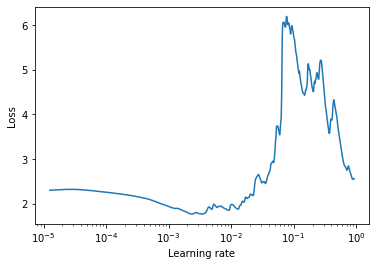

In [11]:
lrfinder.plot()

In [12]:
best_lr = lrfinder.history['lr'][lrfinder.history['loss'].index(lrfinder.best_loss)]
print(best_lr)

0.0034807005884284095


In [0]:
lrfinder.reset()

**Initialise Loss funtion, Optimizer, Scheduler**

In [14]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR , MultiStepLR, ReduceLROnPlateau
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=best_lr,momentum=0.9 ,weight_decay = 0.0001)
scheduler = ReduceLROnPlateau(optimizer, patience = 3,min_lr=1e-4)
print(optimizer.param_groups[0]['lr'])

0.0034807005884284095


**Train the Model for 50 Epochs**

In [15]:
test_loss = []
test_acc = []
train_loss = []
train_acc = []
EPOCHS = 50
best_acc = 0
for epoch in range(EPOCHS):
     print("\n EPOCH:", epoch+1,'LR:',optimizer.param_groups[0]['lr'])
     train_loss, train_acc = train_test.train(model, device, trainloader, optimizer, criterion, epoch)
     test_loss , test_acc = train_test.test(model, device, criterion, testloader)
     scheduler.step(test_loss[-1])
     if(test_acc[-1]>best_acc):
       print("accuracy increased, Saving model....")
       best_acc = test_acc[-1]
       torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': test_loss[-1],
            }, "/content/gdrive/My Drive/school_of_ai/chap10/bestmodel.pt")

  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 1 LR: 0.0034807005884284095


Loss=1.280809998512268 Batch_id=390 Accuracy=42.44: 100%|██████████| 391/391 [00:31<00:00, 12.41it/s]



Test set: Average loss: 0.0088, Accuracy: 5985/10000 (59.85%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 2 LR: 0.0034807005884284095


Loss=1.0469831228256226 Batch_id=390 Accuracy=58.82: 100%|██████████| 391/391 [00:31<00:00, 12.47it/s]



Test set: Average loss: 0.0078, Accuracy: 6463/10000 (64.63%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 3 LR: 0.0034807005884284095


Loss=0.7985937595367432 Batch_id=390 Accuracy=66.50: 100%|██████████| 391/391 [00:31<00:00, 12.46it/s]



Test set: Average loss: 0.0065, Accuracy: 7176/10000 (71.76%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 4 LR: 0.0034807005884284095


Loss=0.5737898945808411 Batch_id=390 Accuracy=70.97: 100%|██████████| 391/391 [00:31<00:00, 12.45it/s]



Test set: Average loss: 0.0057, Accuracy: 7504/10000 (75.04%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 5 LR: 0.0034807005884284095


Loss=0.7354205846786499 Batch_id=390 Accuracy=73.76: 100%|██████████| 391/391 [00:31<00:00, 12.47it/s]



Test set: Average loss: 0.0054, Accuracy: 7735/10000 (77.35%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 6 LR: 0.0034807005884284095


Loss=0.6423512697219849 Batch_id=390 Accuracy=76.63: 100%|██████████| 391/391 [00:31<00:00, 12.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0052, Accuracy: 7710/10000 (77.10%)


 EPOCH: 7 LR: 0.0034807005884284095


Loss=1.0048270225524902 Batch_id=390 Accuracy=77.88: 100%|██████████| 391/391 [00:31<00:00, 12.51it/s]



Test set: Average loss: 0.0044, Accuracy: 8123/10000 (81.23%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 8 LR: 0.0034807005884284095


Loss=0.4960237145423889 Batch_id=390 Accuracy=79.68: 100%|██████████| 391/391 [00:31<00:00, 12.42it/s]



Test set: Average loss: 0.0044, Accuracy: 8187/10000 (81.87%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 9 LR: 0.0034807005884284095


Loss=0.7387120723724365 Batch_id=390 Accuracy=80.73: 100%|██████████| 391/391 [00:31<00:00, 12.42it/s]



Test set: Average loss: 0.0039, Accuracy: 8359/10000 (83.59%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 10 LR: 0.0034807005884284095


Loss=0.4753696024417877 Batch_id=390 Accuracy=82.21: 100%|██████████| 391/391 [00:31<00:00, 12.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 8338/10000 (83.38%)


 EPOCH: 11 LR: 0.0034807005884284095


Loss=0.45541152358055115 Batch_id=390 Accuracy=82.95: 100%|██████████| 391/391 [00:31<00:00, 12.44it/s]



Test set: Average loss: 0.0035, Accuracy: 8479/10000 (84.79%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 12 LR: 0.0034807005884284095


Loss=0.54411780834198 Batch_id=390 Accuracy=83.84: 100%|██████████| 391/391 [00:31<00:00, 12.45it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0044, Accuracy: 8248/10000 (82.48%)


 EPOCH: 13 LR: 0.0034807005884284095


Loss=0.5196834802627563 Batch_id=390 Accuracy=84.80: 100%|██████████| 391/391 [00:31<00:00, 12.48it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8433/10000 (84.33%)


 EPOCH: 14 LR: 0.0034807005884284095


Loss=0.27560263872146606 Batch_id=390 Accuracy=85.60: 100%|██████████| 391/391 [00:31<00:00, 12.45it/s]



Test set: Average loss: 0.0033, Accuracy: 8569/10000 (85.69%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 15 LR: 0.0034807005884284095


Loss=0.4925060272216797 Batch_id=390 Accuracy=86.24: 100%|██████████| 391/391 [00:31<00:00, 12.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 8563/10000 (85.63%)


 EPOCH: 16 LR: 0.0034807005884284095


Loss=0.2188207358121872 Batch_id=390 Accuracy=86.85: 100%|██████████| 391/391 [00:31<00:00, 12.41it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 8555/10000 (85.55%)


 EPOCH: 17 LR: 0.0034807005884284095


Loss=0.43929538130760193 Batch_id=390 Accuracy=87.23: 100%|██████████| 391/391 [00:31<00:00, 12.46it/s]



Test set: Average loss: 0.0034, Accuracy: 8590/10000 (85.90%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 18 LR: 0.0034807005884284095


Loss=0.34495189785957336 Batch_id=390 Accuracy=87.79: 100%|██████████| 391/391 [00:31<00:00, 12.40it/s]



Test set: Average loss: 0.0031, Accuracy: 8733/10000 (87.33%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 19 LR: 0.0034807005884284095


Loss=0.3857041299343109 Batch_id=390 Accuracy=88.43: 100%|██████████| 391/391 [00:31<00:00, 12.43it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0030, Accuracy: 8731/10000 (87.31%)


 EPOCH: 20 LR: 0.0034807005884284095


Loss=0.42454248666763306 Batch_id=390 Accuracy=88.90: 100%|██████████| 391/391 [00:31<00:00, 12.49it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0037, Accuracy: 8577/10000 (85.77%)


 EPOCH: 21 LR: 0.0034807005884284095


Loss=0.1948525458574295 Batch_id=390 Accuracy=89.32: 100%|██████████| 391/391 [00:31<00:00, 12.43it/s]



Test set: Average loss: 0.0029, Accuracy: 8809/10000 (88.09%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 22 LR: 0.0034807005884284095


Loss=0.3740316331386566 Batch_id=390 Accuracy=89.78: 100%|██████████| 391/391 [00:31<00:00, 12.40it/s]



Test set: Average loss: 0.0029, Accuracy: 8812/10000 (88.12%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 23 LR: 0.0034807005884284095


Loss=0.2198270857334137 Batch_id=390 Accuracy=90.03: 100%|██████████| 391/391 [00:31<00:00, 12.37it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8782/10000 (87.82%)


 EPOCH: 24 LR: 0.0034807005884284095


Loss=0.2122116982936859 Batch_id=390 Accuracy=90.66: 100%|██████████| 391/391 [00:31<00:00, 12.51it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8746/10000 (87.46%)


 EPOCH: 25 LR: 0.0034807005884284095


Loss=0.20367975533008575 Batch_id=390 Accuracy=90.60: 100%|██████████| 391/391 [00:31<00:00, 12.46it/s]



Test set: Average loss: 0.0030, Accuracy: 8833/10000 (88.33%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 26 LR: 0.0034807005884284095


Loss=0.2906177043914795 Batch_id=390 Accuracy=91.17: 100%|██████████| 391/391 [00:31<00:00, 12.39it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0031, Accuracy: 8803/10000 (88.03%)


 EPOCH: 27 LR: 0.000348070058842841


Loss=0.1217745915055275 Batch_id=390 Accuracy=93.33: 100%|██████████| 391/391 [00:31<00:00, 12.57it/s]



Test set: Average loss: 0.0023, Accuracy: 9032/10000 (90.32%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 28 LR: 0.000348070058842841


Loss=0.1669338494539261 Batch_id=390 Accuracy=94.19: 100%|██████████| 391/391 [00:31<00:00, 12.44it/s]



Test set: Average loss: 0.0023, Accuracy: 9066/10000 (90.66%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 29 LR: 0.000348070058842841


Loss=0.12726421654224396 Batch_id=390 Accuracy=94.37: 100%|██████████| 391/391 [00:31<00:00, 12.49it/s]



Test set: Average loss: 0.0023, Accuracy: 9079/10000 (90.79%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 30 LR: 0.000348070058842841


Loss=0.11518297344446182 Batch_id=390 Accuracy=94.72: 100%|██████████| 391/391 [00:34<00:00, 11.36it/s]



Test set: Average loss: 0.0023, Accuracy: 9111/10000 (91.11%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 31 LR: 0.000348070058842841


Loss=0.2193044126033783 Batch_id=390 Accuracy=94.65: 100%|██████████| 391/391 [00:32<00:00, 12.18it/s]



Test set: Average loss: 0.0022, Accuracy: 9121/10000 (91.21%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 32 LR: 0.000348070058842841


Loss=0.17607875168323517 Batch_id=390 Accuracy=94.86: 100%|██████████| 391/391 [00:31<00:00, 12.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9114/10000 (91.14%)


 EPOCH: 33 LR: 0.000348070058842841


Loss=0.211155503988266 Batch_id=390 Accuracy=94.99: 100%|██████████| 391/391 [00:31<00:00, 12.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9103/10000 (91.03%)


 EPOCH: 34 LR: 0.000348070058842841


Loss=0.2755281925201416 Batch_id=390 Accuracy=94.98: 100%|██████████| 391/391 [00:31<00:00, 12.33it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9108/10000 (91.08%)


 EPOCH: 35 LR: 0.000348070058842841


Loss=0.11200795322656631 Batch_id=390 Accuracy=95.14: 100%|██████████| 391/391 [00:31<00:00, 12.22it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9113/10000 (91.13%)


 EPOCH: 36 LR: 0.000348070058842841


Loss=0.11725976318120956 Batch_id=390 Accuracy=95.16: 100%|██████████| 391/391 [00:31<00:00, 12.31it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9113/10000 (91.13%)


 EPOCH: 37 LR: 0.000348070058842841


Loss=0.10568960011005402 Batch_id=390 Accuracy=95.27: 100%|██████████| 391/391 [00:31<00:00, 12.27it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9114/10000 (91.14%)


 EPOCH: 38 LR: 0.000348070058842841


Loss=0.13016662001609802 Batch_id=390 Accuracy=95.24: 100%|██████████| 391/391 [00:31<00:00, 12.24it/s]



Test set: Average loss: 0.0022, Accuracy: 9133/10000 (91.33%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 39 LR: 0.000348070058842841


Loss=0.1823766678571701 Batch_id=390 Accuracy=95.45: 100%|██████████| 391/391 [00:31<00:00, 12.30it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9116/10000 (91.16%)


 EPOCH: 40 LR: 0.000348070058842841


Loss=0.1960144340991974 Batch_id=390 Accuracy=95.52: 100%|██████████| 391/391 [00:31<00:00, 12.28it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9111/10000 (91.11%)


 EPOCH: 41 LR: 0.000348070058842841


Loss=0.11021063476800919 Batch_id=390 Accuracy=95.41: 100%|██████████| 391/391 [00:31<00:00, 12.32it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9118/10000 (91.18%)


 EPOCH: 42 LR: 0.000348070058842841


Loss=0.16417109966278076 Batch_id=390 Accuracy=95.55: 100%|██████████| 391/391 [00:31<00:00, 12.32it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9120/10000 (91.20%)


 EPOCH: 43 LR: 0.0001


Loss=0.1592937558889389 Batch_id=390 Accuracy=95.83: 100%|██████████| 391/391 [00:31<00:00, 12.29it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0023, Accuracy: 9124/10000 (91.24%)


 EPOCH: 44 LR: 0.0001


Loss=0.10694173723459244 Batch_id=390 Accuracy=95.79: 100%|██████████| 391/391 [00:32<00:00, 12.18it/s]



Test set: Average loss: 0.0023, Accuracy: 9146/10000 (91.46%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 45 LR: 0.0001


Loss=0.12488411366939545 Batch_id=390 Accuracy=95.97: 100%|██████████| 391/391 [00:32<00:00, 12.21it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9138/10000 (91.38%)


 EPOCH: 46 LR: 0.0001


Loss=0.15699926018714905 Batch_id=390 Accuracy=95.87: 100%|██████████| 391/391 [00:31<00:00, 12.30it/s]



Test set: Average loss: 0.0022, Accuracy: 9150/10000 (91.50%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 47 LR: 0.0001


Loss=0.11596252024173737 Batch_id=390 Accuracy=96.08: 100%|██████████| 391/391 [00:31<00:00, 12.23it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9143/10000 (91.43%)


 EPOCH: 48 LR: 0.0001


Loss=0.13942278921604156 Batch_id=390 Accuracy=95.93: 100%|██████████| 391/391 [00:31<00:00, 12.32it/s]



Test set: Average loss: 0.0023, Accuracy: 9152/10000 (91.52%)

accuracy increased, Saving model....


  0%|          | 0/391 [00:00<?, ?it/s]


 EPOCH: 49 LR: 0.0001


Loss=0.06890751421451569 Batch_id=390 Accuracy=96.09: 100%|██████████| 391/391 [00:32<00:00, 12.19it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.0022, Accuracy: 9143/10000 (91.43%)


 EPOCH: 50 LR: 0.0001


Loss=0.23130135238170624 Batch_id=390 Accuracy=95.97: 100%|██████████| 391/391 [00:31<00:00, 12.26it/s]



Test set: Average loss: 0.0022, Accuracy: 9151/10000 (91.51%)



**Load the Best Accuracy Model**


In [16]:
optimizer = optim.SGD(model.parameters(), lr=best_lr,momentum=0.9 ,weight_decay = 0.0005)
checkpoint = torch.load("/content/gdrive/My Drive/school_of_ai/chap10/bestmodel.pt")
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
print("Loaded the best model")

Loaded the best model


In [17]:
evaluate.evaluate_accuracy(model, device, testloader)

Accuracy of the network on the 10000 test images: 91 %


In [18]:
evaluate.evaluate_classwise_accuracy(model, device, classes, testloader)

Accuracy of plane : 96 %
Accuracy of   car : 88 %
Accuracy of  bird : 97 %
Accuracy of   cat : 70 %
Accuracy of  deer : 95 %
Accuracy of   dog : 87 %
Accuracy of  frog : 100 %
Accuracy of horse : 94 %
Accuracy of  ship : 93 %
Accuracy of truck : 92 %


**Plot Loss Change in train and test**


Text(0.5, 1.0, 'Test Accuracy')

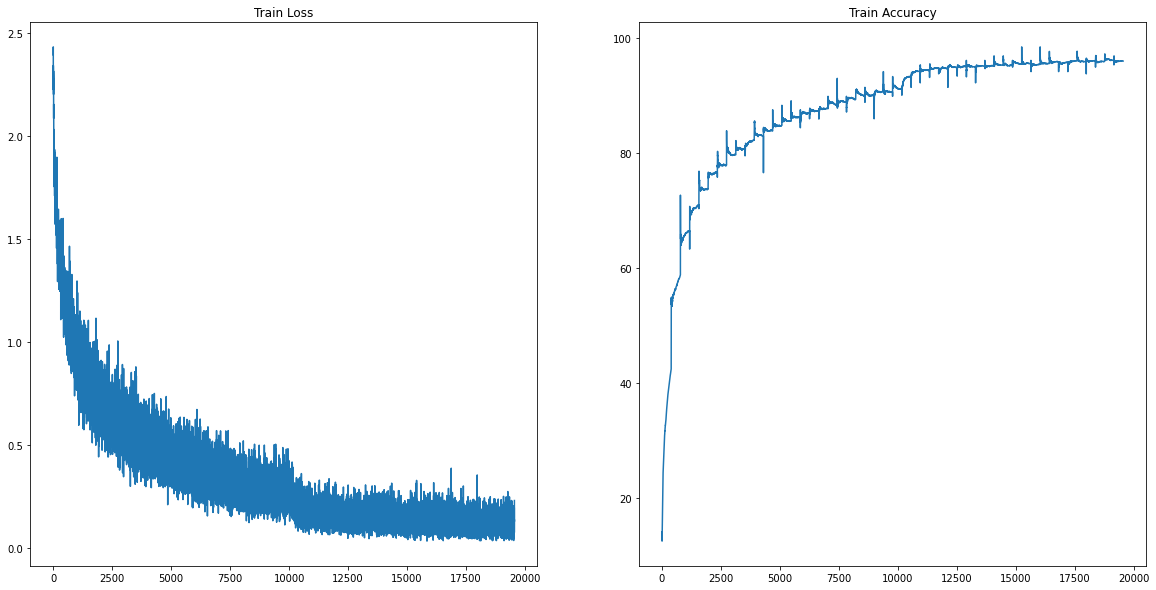

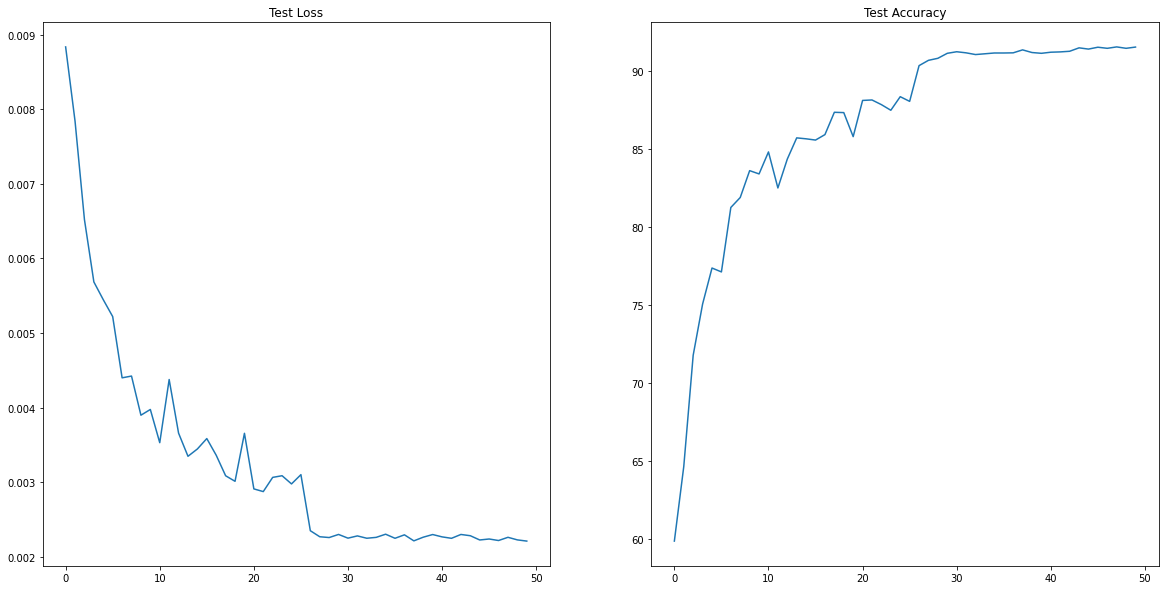

In [23]:
import matplotlib.pyplot as plt

train_fig, train_axs = plt.subplots(1,2, figsize=(20,10))
train_axs[0].plot(train_loss)
train_axs[0].set_title("Train Loss")
train_axs[1].plot(train_acc)
train_axs[1].set_title("Train Accuracy")

test_fig, test_axs = plt.subplots(1,2, figsize=(20,10))
test_axs[0].plot(test_loss)
test_axs[0].set_title("Test Loss")
test_axs[1].plot(test_acc)
test_axs[1].set_title("Test Accuracy")

**Plot changes in Training and Test accuracy**

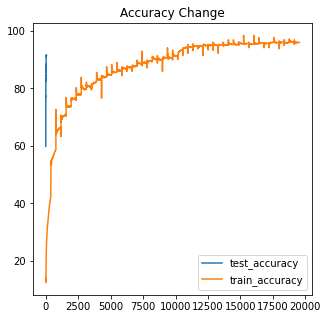

In [29]:
def plot_curve(curves,title,Figsize = (7,7)):
    fig = plt.figure(figsize=Figsize)
    ax = plt.subplot()
    for curve in curves:
        ax.plot(curve[0], label=curve[1])
        plt.title(title)
    ax.legend()
    plt.show()
curves = [(test_acc,"test_accuracy"),(train_acc,"train_accuracy")]
plot_curve(curves =curves ,title = "Accuracy Change",Figsize = (5,5))

In [0]:
import shutil
def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')

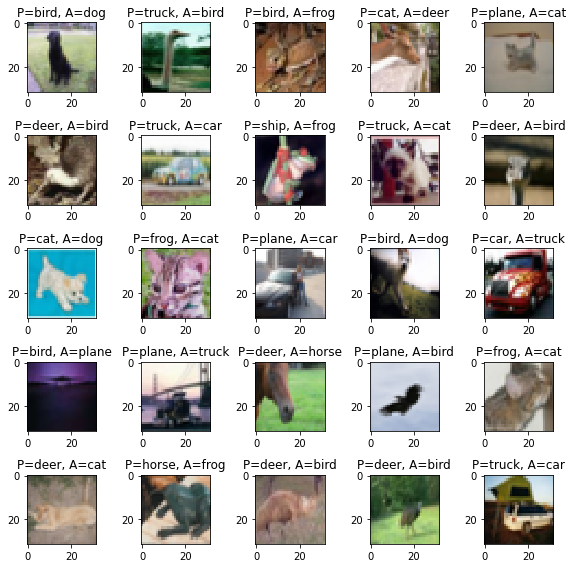

In [31]:
misclassified_images = evaluate.show_misclassified_images(model, device, testloader, classes)

**GradCam View of misclassified images(for all 4 layers)**


/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


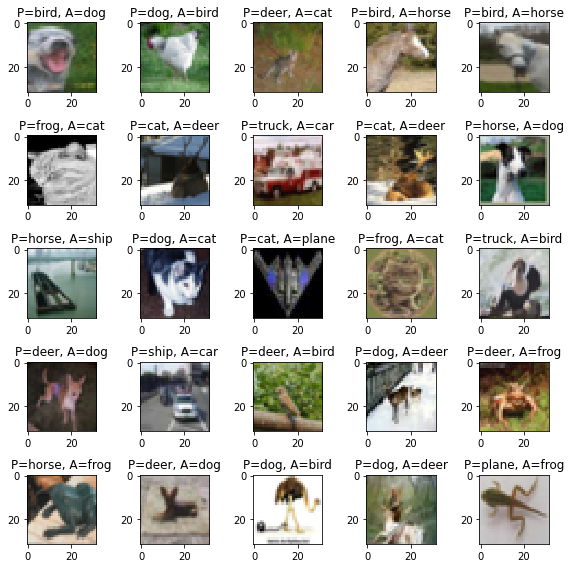

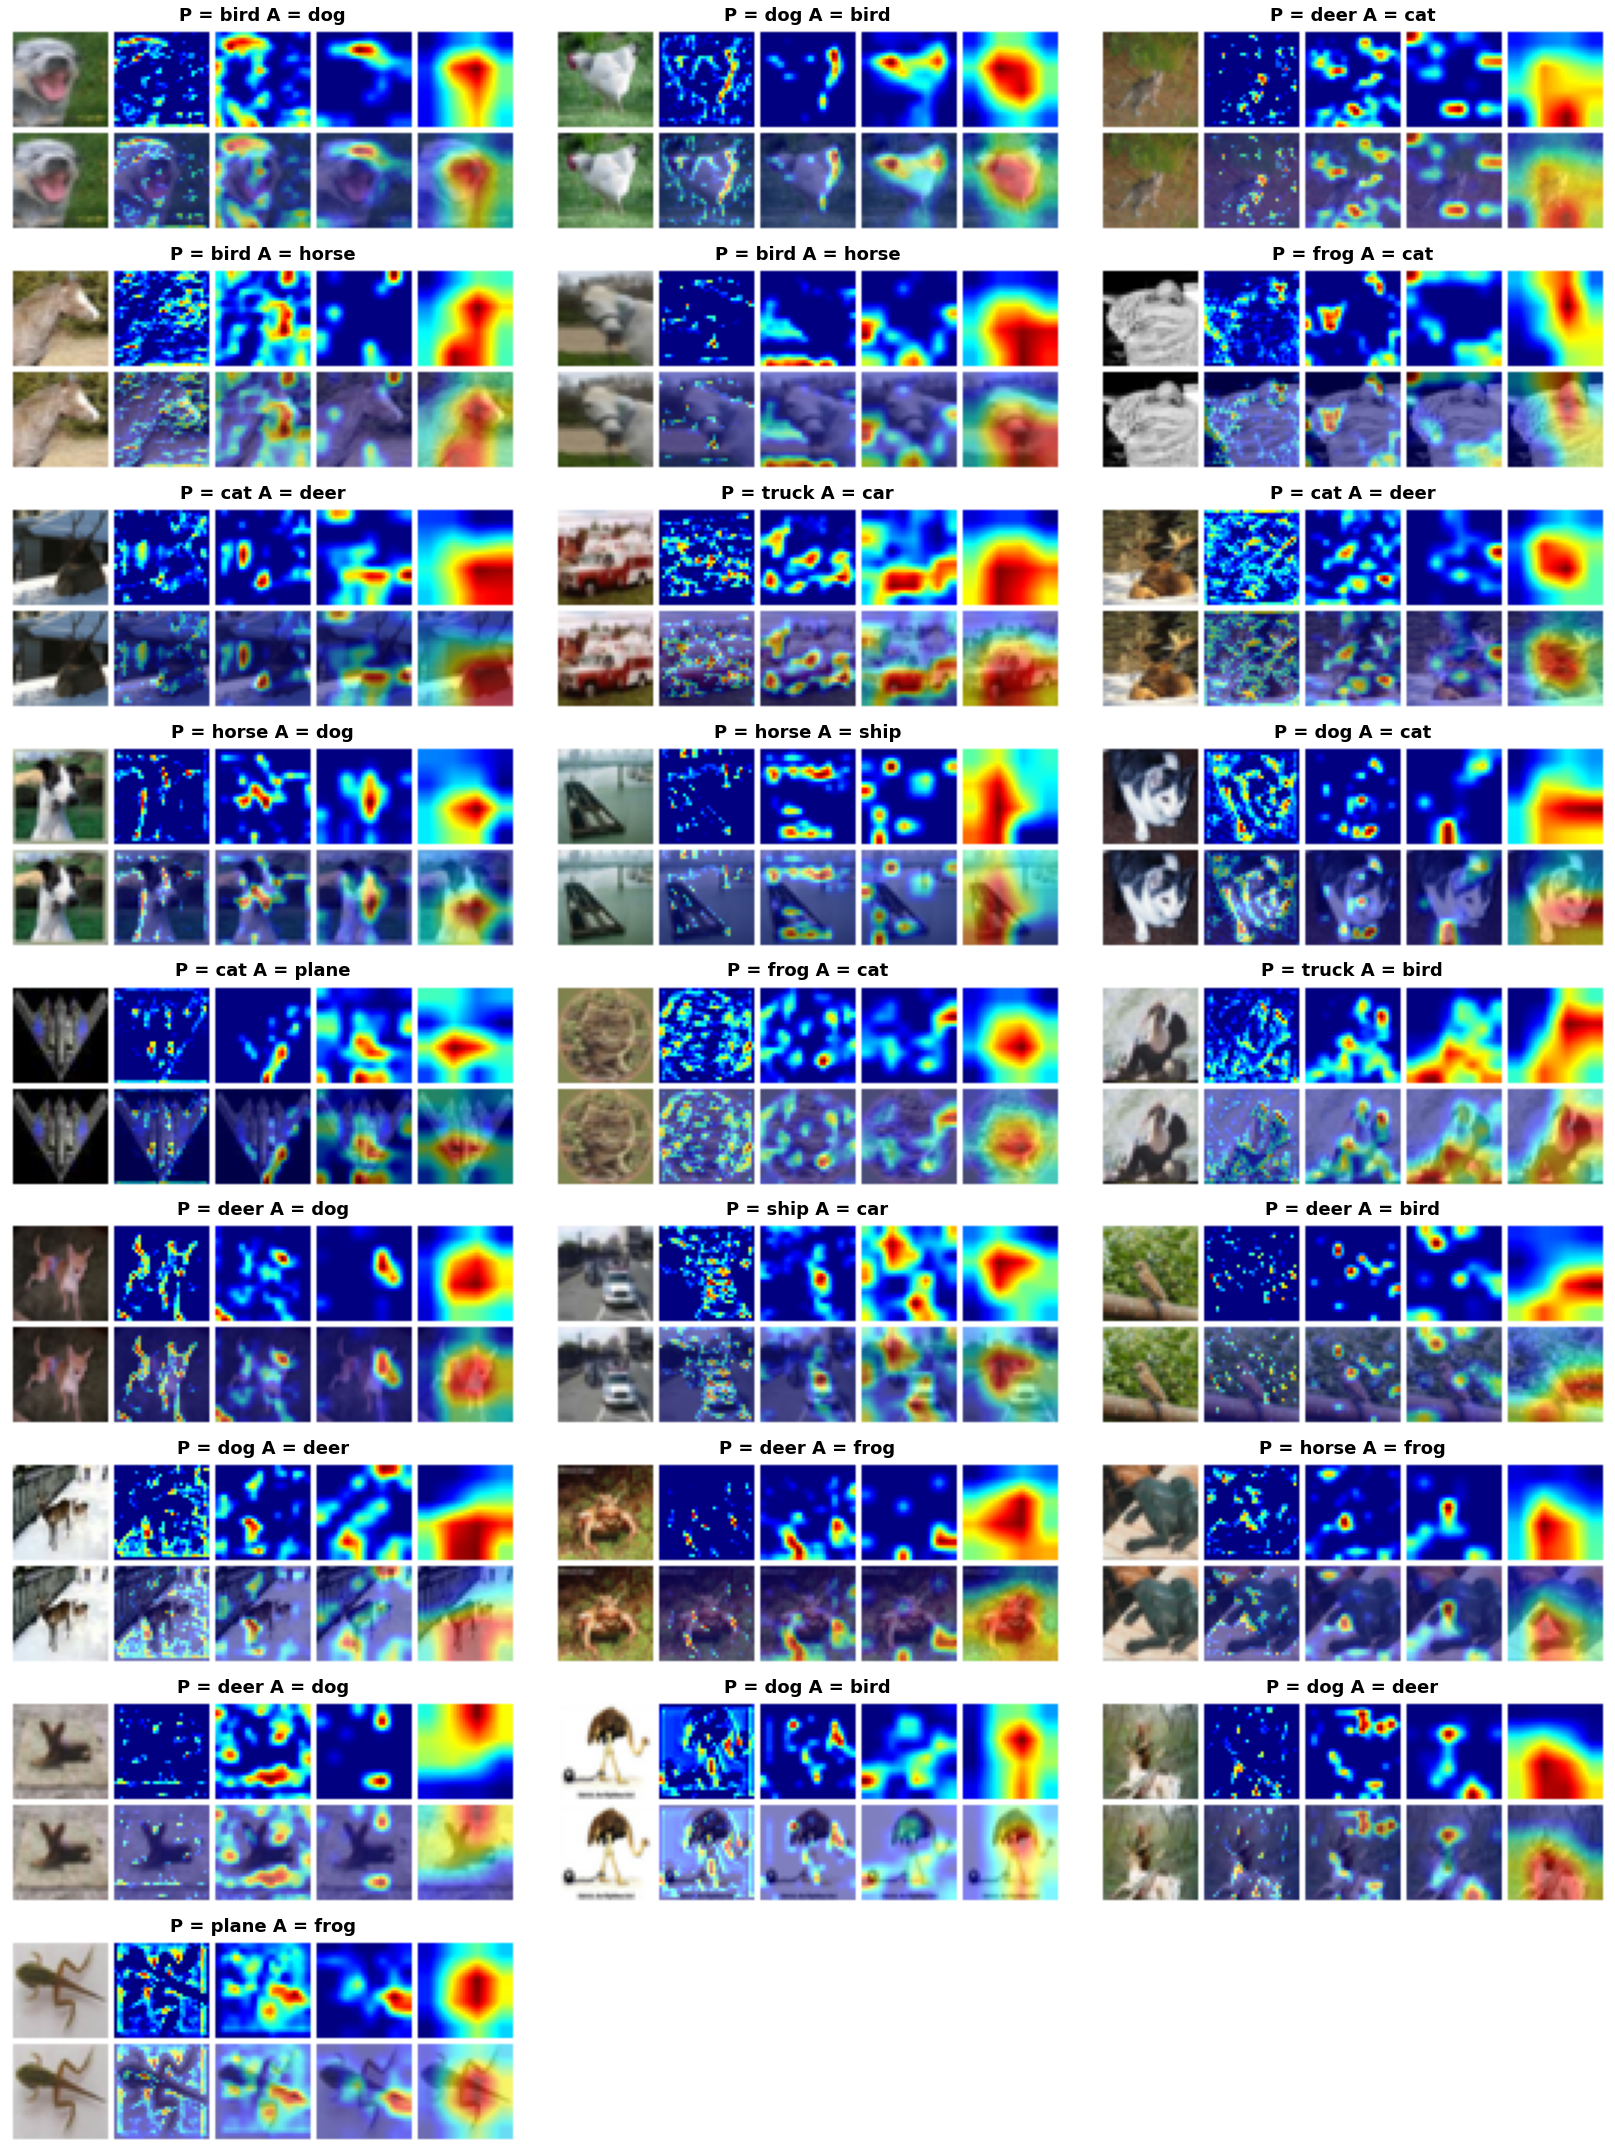

In [32]:
layers = [model.layer1,model.layer2,model.layer3,model.layer4]
miscalssified_images = evaluate.show_misclassified_images(model, device, testloader, classes)
gradcam.GradCamView(miscalssified_images,model,classes,layers)